In [1]:
import numpy as np

from ClassifierMetric.utils.plots import plot_class_score
from ClassifierMetric.datamodules.jetnet.datasets import JetNetDataset
from ClassifierMetric.datamodules.jetnet.dataloaders import JetNetDataLoader
from ClassifierMetric.utils.trainer import ModelClassifierTest
from ClassifierMetric.models.particlenet import ParticleNet
from ClassifierMetric.configs.particlenet_config import ParticleNetConfig

In [2]:
def evaluate_models(model_dir, device='cuda:0'):
    
    config = ParticleNetConfig.load(path=model_dir + "/configs.json")
    config.workdir = model_dir
    config.device = device
    particlenet = ParticleNet(model_config=config)
    datasets = JetNetDataset(dir_path = '/home/df630/ClassifierMetric/data/', 
                            datasets = config.datasets,
                            class_labels = config.labels,
                            num_jets = config.num_jets,
                            num_constituents = config.num_constituents,
                            preprocess = config.preprocess,
                            particle_features = config.features,
                            remove_negative_pt = True
                            ) 
    dataloader = JetNetDataLoader(datasets=datasets, data_split_fracs=config.data_split_fracs, batch_size=config.batch_size)
    classifier = ModelClassifierTest(classifier = particlenet, 
                                    dataloader = dataloader,
                                    epochs = config.epochs, 
                                    lr = config.lr, 
                                    early_stopping = config.early_stopping,
                                    warmup_epochs = config.warmup_epochs,
                                    workdir = config.workdir,
                                    seed = config.seed)

    classifier.load_model(path=config.workdir + '/best_model.pth')
    classifier.test(class_labels=config.labels)
    return classifier, config

+------------------+----------------------------------------------------------------------+
| Key              | Value                                                                |
+------------------+----------------------------------------------------------------------+
| data_name        | tops                                                                 |
| features         | ['eta_rel', 'phi_rel', 'pt_rel', 'e_rel', 'R']                       |
| preprocess       | ['standardize']                                                      |
| datasets         | flow_midpoint: ['fm_tops30_mp200nfe.h5', 'etaphipt']                 |
|                  | diff_midpoint: ['diff_tops30_midpoint_100_csts.h5', 'etaphipt_frac'] |
|                  | flow_euler: ['fm_tops30_eu200nfe.h5', 'etaphipt']                    |
|                  | diff_euler: ['diff_tops30_euler_200_csts.h5', 'etaphipt_frac']       |
|                  | diff_ddim: ['diff_tops30_ddim_200_csts.h5', 'etaphipt_frac'

testing:   0%|          | 0/444 [00:00<?, ?it/s]

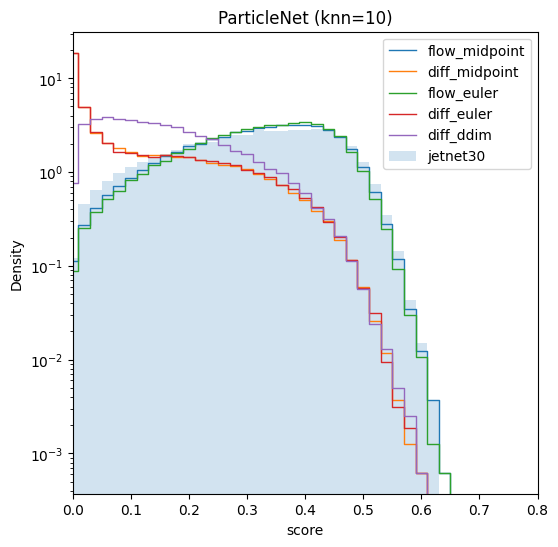

In [3]:
classifier, config = evaluate_models(model_dir="/home/df630/ClassifierMetric/results/tops.ParticleNet__1", device='cuda:0')

plot_class_score(predictions=classifier.predictions,
                class_labels=config.labels,
                reference='flow_midpoint',
                title=config.model_name + ' (knn={})'.format(config.num_knn),
                figsize=(6,6), 
                xlim=(0,0.8),
                bins=np.arange(-0.03, 1.03, 0.02),
                workdir=config.workdir,
                density=True,
                lw =1,
                legend_loc='upper right')

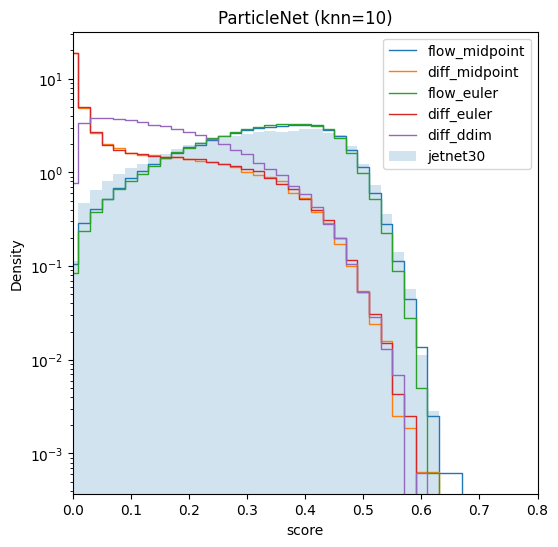

In [12]:
plot_class_score(predictions=classifier.predictions,
                class_labels=config.labels,
                reference='flow_midpoint',
                title=config.model_name + ' (knn={})'.format(config.num_knn),
                figsize=(6,6), 
                xlim=(0,0.8),
                bins=np.arange(-0.03, 1.03, 0.02),
                workdir=config.workdir,
                density=True,
                lw =1,
                legend_loc='upper right')

+------------------+---------------------------------------------------------------------------+
| Key              | Value                                                                     |
+------------------+---------------------------------------------------------------------------+
| data_name        | tops                                                                      |
| features         | ['eta_rel', 'phi_rel', 'pt_rel', 'e_rel', 'R']                            |
| preprocess       | ['standardize']                                                           |
| datasets         | flow_midpoint: ['fm_tops30_cond_mp200nfe.h5', 'etaphipt']                 |
|                  | diff_midpoint: ['diff_tops30_cond_midpoint_100_csts.h5', 'etaphipt_frac'] |
|                  | flow_euler: ['fm_tops30_cond_eu200nfe.h5', 'etaphipt']                    |
|                  | diff_euler: ['diff_tops30_cond_euler_200_csts.h5', 'etaphipt_frac']       |
|                  | diff_ddim

testing:   0%|          | 0/444 [00:00<?, ?it/s]

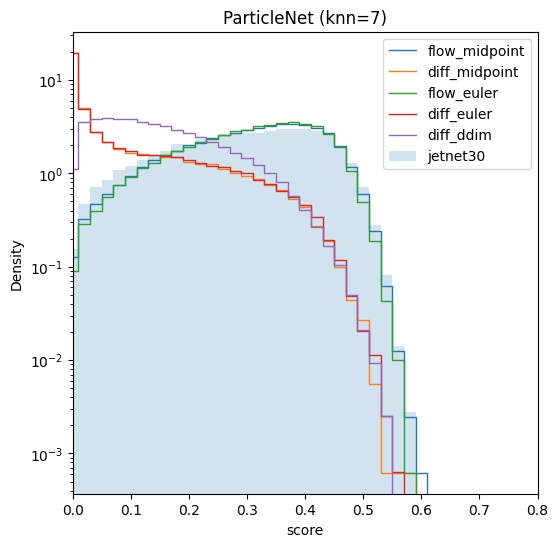

In [13]:
classifier, config = evaluate_models(model_dir="/home/df630/ClassifierMetric/results/tops.ParticleNet__2", device='cuda:0')

plot_class_score(predictions=classifier.predictions,
                class_labels=config.labels,
                reference='flow_midpoint',
                title=config.model_name + ' (knn={})'.format(config.num_knn),
                figsize=(6,6), 
                xlim=(0,0.8),
                bins=np.arange(-0.03, 1.03, 0.02),
                workdir=config.workdir,
                density=True,
                lw =1,
                legend_loc='upper right')

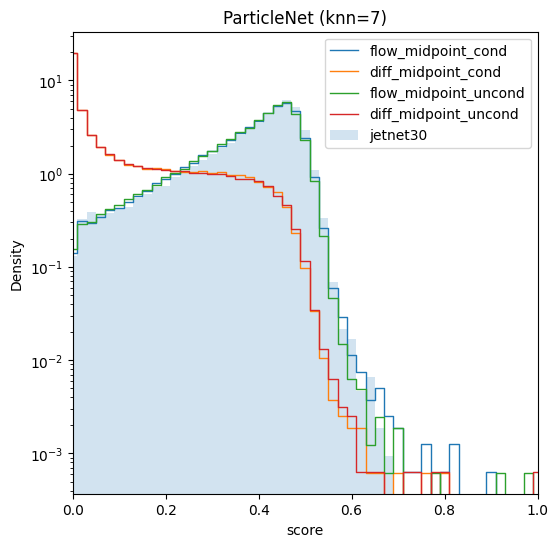

In [15]:
# classifier, config = evaluate_models(model_dir="/home/df630/ClassifierMetric/results/tops.ParticleNet__3", device='cuda:0')

plot_class_score(predictions=classifier.predictions,
                class_labels=config.labels,
                reference='flow_midpoint_cond',
                title=config.model_name + ' (knn={})'.format(config.num_knn),
                figsize=(6,6), 
                xlim=(0,1),
                bins=np.arange(-0.03, 1.03, 0.02),
                workdir=config.workdir,
                density=True,
                lw =1,
                legend_loc='upper right')

In [ ]:
for jet in datasets:
    print(jet['mask'])
    print(jet['mask'])
    print(jet['mask'])

    break